In [1]:
# Python
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prophet import Prophet
import os
os.listdir()
path = open('document.txt', 'r').read().strip()

In [2]:
files = os.listdir(path)
files.sort()
print(files)
print(path + files[0])
test_data_street = files[-3]
files = files[:-3]
print(files)
print(test_data_street)


['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather', '2021_street.feather']
C:\Users\20192638\Documents\Data Challenge 2\street2015_street.feather
['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather']
2019_street.feather


## Notes Police forces
apparently 'Greater Manchester Police' force was removed from 2020 to 2021 <br><br>
'Police Service of Northern Ireland' is included from 2011 onwards

## idea
instead of only count of crimes we select a specific crime type in a specific district

In [42]:
def DistrictCrimeData(district, allYears, crime):
    df_district = pd.DataFrame([])
    if allYears:
        for i in files:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within', 'Crime type']]
            df_new = df_new[df_new['Falls within']==district]
            if len(crime) != 0:
                df_new = df_new[df_new['Crime type'].isin(crime)]
            df_district = pd.concat([df_district, df_new], ignore_index=True)
            
    #only last year's data for testing
    else:
        df_district = pd.read_feather(f"{path}/{test_data_street}")
        df_district = df_district[['Month', 'Falls within', 'Crime type']]
        df_district = df_district[df_district['Falls within']==district]
        if len(crime) != 0:
            df_district = df_district[df_district['Crime type'].isin(crime)]

    return df_district

df_data = DistrictCrimeData(district='South Wales Police', allYears=True, crime=['Violence and sexual offences'])
df_test_data = DistrictCrimeData(district='South Wales Police', allYears=False, crime=['Violence and sexual offences'])


In [43]:
#Total crimes
def Count_by_district(district):
    df_data = pd.DataFrame([])
    for i in files:
        if 'df_data' not in globals():
            df_data = pd.read_feather(f"{path}/{i}")
            df_data = df_data[['Month', 'Falls within']]
            df_data = df_data[df_data['Falls within']==district]
        else:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within']]
            df_new = df_new[df_new['Falls within']==district]
            df_data = pd.concat([df_data, df_new], ignore_index=True)

    return df_data

df_district_count = Count_by_district(district='South Wales Police')
df_district_count.head(5)





,Month,Falls within
0,2015-12,South Wales Police
1,2015-12,South Wales Police
2,2015-12,South Wales Police
3,2015-12,South Wales Police
4,2015-12,South Wales Police


In [44]:
#district = df_data[df_data['Falls within']=='South Wales Police']
#del df_data
district = df_data.copy()
predict = {}

district = district.sort_values(by=['Month'])
months = district['Month'].unique()
for i in months:
    predict[i] = len(district[district['Month']==i])
predict = pd.DataFrame({'ds': list(predict.keys()), 'y': list(predict.values())})
predict['ds'] = pd.to_datetime(predict['ds'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 33.0, 'Years')

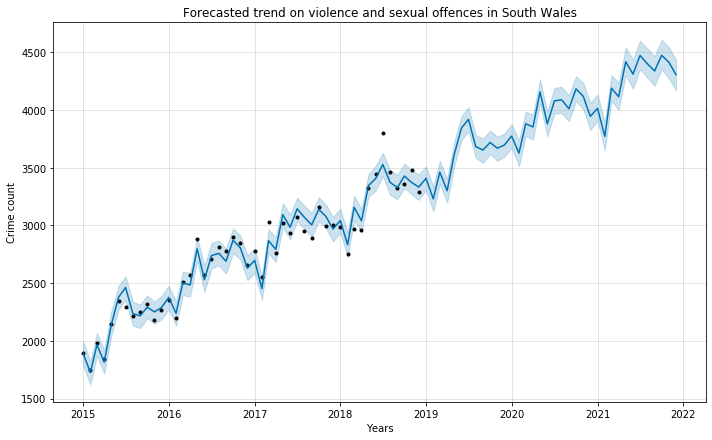

In [45]:
m = Prophet(seasonality_mode='additive').fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title('Forecasted trend on violence and sexual offences in South Wales')
ax.set_ylabel('Crime count')
ax.set_xlabel('Years')

C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


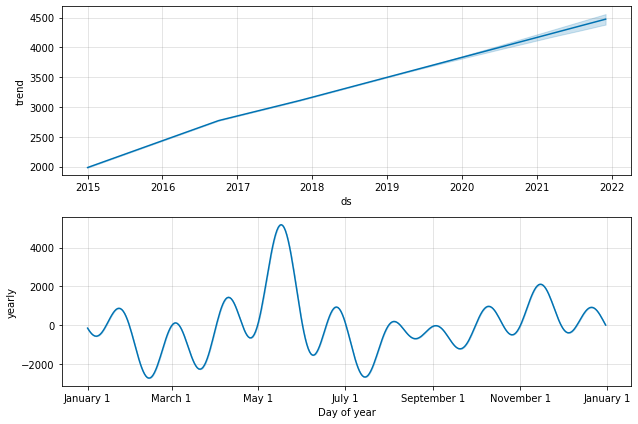

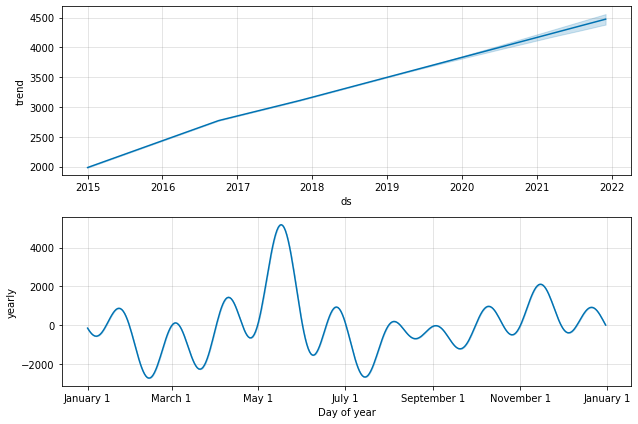

In [46]:
m.plot_components(fcst)

### Evaluation



In [115]:

fcst = fcst.sort_values(by='ds')
predict_2019 = []
for i, row in fcst.iterrows():
    #print(row[0] < pd.Timestamp(2019, 1, 1, 0))
    if row[0] >= pd.Timestamp(2019, 1, 1, 0) and row[0] <= pd.Timestamp(2019, 12, 31, 0) :
        predict_2019.append(row[2])

df_2019 = df_test_data['Month'].value_counts()
df_2019 = df_2019.sort_index()
true_2019 = df_2019.values


mse = np.square(np.subtract(true_2019,predict_2019)).mean()
print('mse',mse)
rmse = mse**0.5
print('rmse', rmse)
sum=0
for i in range(len(true_2019)):
    sum += abs(true_2019[i] - predict_2019[i])
mae = sum/len(true_2019)
print('mae', mae)

mse 37316.18177042565
rmse 193.1739676313184
mae 150.33068684582545


### Cross validation


In [118]:
cutoffs = pd.date_range(start='2018-01-01', end='2018-03-01', freq='2MS')
df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '62 days')

df_p = performance_metrics(df_cv)
print(df_p)
df_p['rmse'].mean()

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 31 days   1706.787011   41.313279   37.465133  0.013361  0.013361  0.013274   
1 59 days  35662.719747  188.845756  188.845756  0.063606  0.063606  0.061645   
2 61 days  12249.570232  110.677777  110.677777  0.033317  0.033317  0.033881   

   coverage  
0       0.5  
1       0.0  
2       0.0  


113.61227065251592

C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for mult

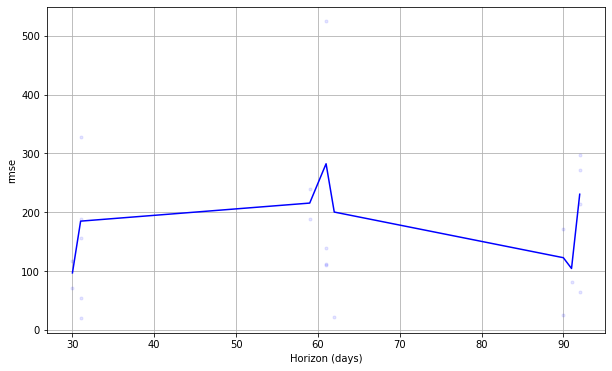

In [41]:
from prophet.plot import plot_cross_validation_metric 
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [42]:
cutoffs = pd.date_range(start='2018-01-01', end='2019-01-01', freq='2MS')
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
for params in all_params:
    m = Prophet(**params).fit(predict)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='62 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE027F97B8>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE0273D358>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE01FFCCF8>
INFO:prophet:Disabling weekly seasonality. 

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  195.185927
1                     0.001                     0.10  194.570993
2                     0.001                     1.00  187.347064
3                     0.001                    10.00  184.474727
4                     0.010                     0.01  206.414790
5                     0.010                     0.10  192.699391
6                     0.010                     1.00  184.511773
7                     0.010                    10.00  184.190150
8                     0.100                     0.01  226.482822
9                     0.100                     0.10  213.158686
10                    0.100                     1.00  211.909082
11                    0.100                    10.00  211.343737
12                    0.500                     0.01  248.989782
13                    0.500                     0.10  319.209247
14                    0.5

In [43]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


### Other data aggregation


In [5]:
df_data0 = pd.read_feather(f"{path}/{files[0]}")
df_data1 = pd.read_feather(f"{path}/{files[1]}")
df_data2 = pd.read_feather(f"{path}/{files[2]}")
df_data3 = pd.read_feather(f"{path}/{files[3]}")


In [6]:

crimes = df_data0['Crime type'].value_counts().keys()
crimeCount0 = df_data0['Crime type'].value_counts()
crimeCount1 = df_data1['Crime type'].value_counts()
crimeCount2 = df_data2['Crime type'].value_counts()
crimeCount3 = df_data3['Crime type'].value_counts()
dic0 = dict(zip(crimes, crimeCount0))
dic1 = dict(zip(crimes, crimeCount1))
dic2 = dict(zip(crimes, crimeCount2))
dic3 = dict(zip(crimes, crimeCount3))
df_crime_distribution = pd.DataFrame(columns=crimes)
df_crime_distribution = df_crime_distribution.append(dic0, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic1, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic2, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic3, ignore_index=True)
df_crime_distribution

,Anti-social behaviour,Violence and sexual offences,Criminal damage and arson,Other theft,Burglary,Vehicle crime,Shoplifting,Public order,Drugs,Bicycle theft,Theft from the person,Other crime,Robbery,Possession of weapons
0,1875251,1049161,549145,505583,410576,368568,339123,193944,151248,88163,83092,63224,51628,25162
1,1852894,1233265,571144,497262,409399,394556,362286,254027,137670,86726,83586,74172,56130,31229
2,1712771,1512942,603824,544405,458419,445689,389625,367198,136784,102983,100667,93174,74329,40137
3,1789313,1436624,577112,552890,467788,435702,430086,379399,148270,103570,101242,96848,82621,45848


In [7]:
df_crime_distribution1 = pd.DataFrame(columns=crimes)
df_crime_distribution1 = df_crime_distribution1.append(dic0, ignore_index=True)

In [47]:
#df_crime_distribution.to_feather(f"C:/Users/Arcane/Documents/Data Challenge 2/extra")

Text(0.5, 1.0, 'Amount of crime for each crime type per year')

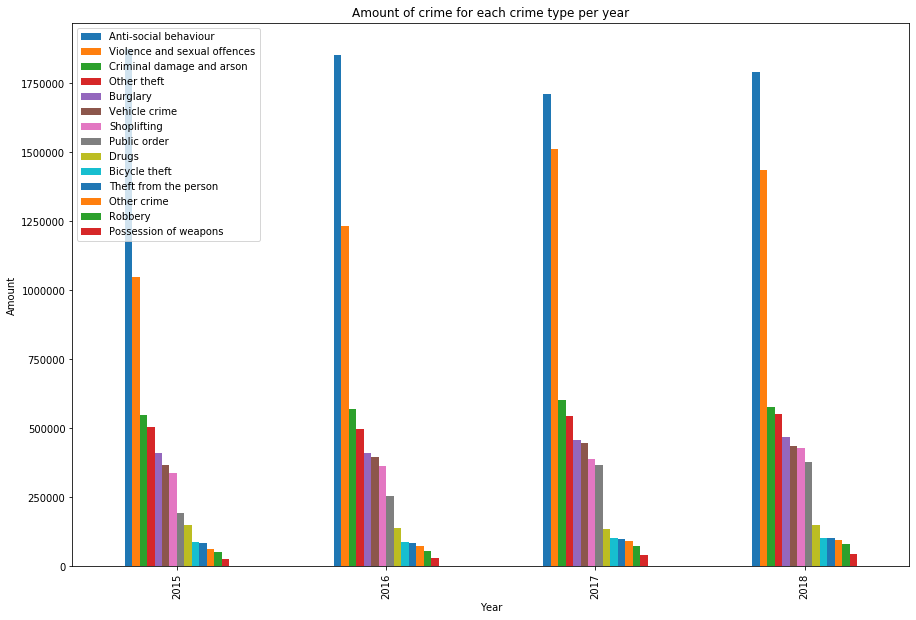

In [8]:
ax = df_crime_distribution.plot.bar(figsize=(15,10))
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019])
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('Amount of crime for each crime type per year')


   Total crimes
0       5753868
1       6044346
2       6582947
3       6647313
4       6505602
5       6367002


([<matplotlib.axis.XTick at 0x1ee02805cf8>,
 <a list of 6 Text xticklabel objects>)

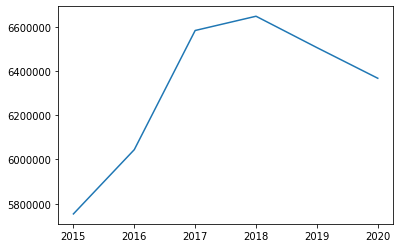

In [49]:
sum0 = sum(crimeCount0)
sum1 = sum(crimeCount1)
sum2 = sum(crimeCount2)
sum3 = sum(crimeCount3)

df_total_crimes = pd.DataFrame(data = {'Total crimes' : [sum0,sum1,sum2,sum3]})
print(df_total_crimes)
plt.plot(df_total_crimes)
plt.rcParams["figure.figsize"] = (10,5)
plt.xticks([0, 1, 2, 3], ['2015', '2016', '2017', '2018'])

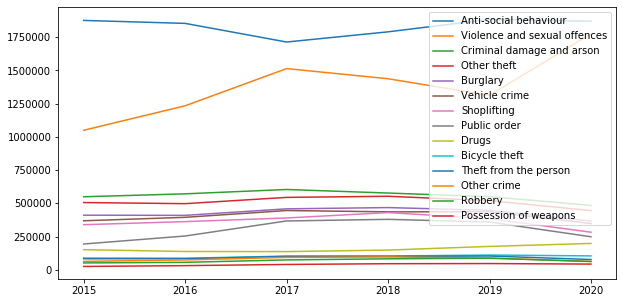

In [50]:
plt.plot(df_crime_distribution)
plt.rcParams["figure.figsize"] = (15,10)
plt.xticks([0, 1, 2, 3], ['2015', '2016', '2017', '2018'])
plt.legend(crimes, loc='upper right')